<a href="https://colab.research.google.com/github/HsiuWen/DL_course_MS_HPC_IA/blob/main/Lab5_reinforcement_learning_Q.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 5 Implementation of q-learning on simulated game

This notebook has been prepared by Hsiu-Wen Chang from MINES ParisTech
Shall you have any problem, send me [email](hsiu-wen.chang_joly@mines-paristech.fr)

In this practical lesson, we are going to implement the reinforcement learning using Q-learning. We are going to train it on how to play a mountain car. The agent (a car) is started at the bottom of a valley. For any given state the agent may choose to accelerate to the left, right or cease any acceleration.
        

1. The observation space contains two values (car position and car velocity)
2. The available actions are:
    0: push left
    1: nothing
    2: push right
3. If the car reaches the flag, the game is over
4. If the car takes one action and failes to reach the flag, the penalty -1 will be given. 


In [ ]:
!apt-get install x11-utils > /dev/null 2>&1
!pip install pyglet==v1.4.0
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()

[OpenAI Gym](https://gym.openai.com/docs/) aims to provide an easy-to-setup general-intelligence benchmark with a wide variety of different environments. The goal is to standardize how environments are defined in AI research publications so that published research becomes more easily reproducible. The project claims to provide the user with a simple interface. As of June 2017, developers can only use Gym with Python.

In [ ]:
%pip install -U gym>=0.21.0
%pip install -U gym[atari]

In [ ]:
import gym
import numpy as np
import matplotlib.pyplot as plt
env = gym.make('MountainCar-v0')

In [ ]:
import atari_py

In [ ]:
atari_py.list_games()


In [ ]:
def query_environment(name):
  env = gym.make(name)
  spec = gym.spec(name)
  print(f"Action Space: {env.action_space}")
  print(f"Observation Space: {env.observation_space}")
  print(f"Max Episode Steps: {spec.max_episode_steps}")
  print(f"Nondeterministic: {spec.nondeterministic}")
  print(f"Reward Range: {env.reward_range}")
  print(f"Reward Threshold: {spec.reward_threshold}")

In [ ]:
query_environment("MountainCar-v0")

In [ ]:
env.reset()

prev_screen = env.render(mode='rgb_array')
plt.imshow(prev_screen)

for i in range(50):
  action = env.action_space.sample()
  obs, reward, done, info = env.step(action)
  screen = env.render(mode='rgb_array')
  
  plt.imshow(screen)
  ipythondisplay.clear_output(wait=True)
  ipythondisplay.display(plt.gcf())

  if done:
    break

ipythondisplay.clear_output(wait=True)
env.close()

Now we need to define our search space for the q matrix. Here we use the range of observation_space and divided by resolution 20

In [ ]:
DISCRETE_OS_SIZE = [20]*len(env.observation_space.high)
print('Highest number {}'.format(env.observation_space.high))
print('Lowest number {}'.format(env.observation_space.low))
discrete_os_win_size = (env.observation_space.high-env.observation_space.low)/DISCRETE_OS_SIZE
print(DISCRETE_OS_SIZE)

Here are the parameters that control the way to learn. 
We apply the idea of epsilon decay that help use to decrease the chance to do random behavior for exploration. 

In [ ]:
# training parameter
LEARNING_RATE = 0.1
DISCOUNT = 0.95 # the weight of how to meausre the future reward vs current reward. [0.1]
EPISODES = 4000 # training epochs
SHOW_EVERY = 500 #show information every 500 loops

epsilon = 0.5 #[0~1] higher value for higher random for exploration behavior
START_EPSILON_DECAYING = 1
END_EPSILON_DECAYING = EPISODES // 2
print('END_EPSILON_DECAYING:{}'.format(END_EPSILON_DECAYING))
epsilon_decay_value = epsilon/(END_EPSILON_DECAYING-START_EPSILON_DECAYING)

# Now we create a Q(s,a) matrix with random values
q_table = np.random.uniform(low=-2,high=0,size = (DISCRETE_OS_SIZE+[env.action_space.n]))
print(q_table.shape)
ep_rewards = []
aggr_ep_rewards = {'ep':[],'avg':[],'min':[],'max':[]}

To simply the task, we discrete the state to match the q-matrix we have

In [ ]:
def get_discrete_state(state):
    discrete_state = (state-env.observation_space.low)/discrete_os_win_size
    return tuple(discrete_state.astype(np.int))

In [ ]:
# Create a folder to save the q table
!mkdir qtables

# Now we start to train the agent

In [ ]:
for episode in range(EPISODES):
    episode_reward = 0

    # Don't do render in Colab
    render = False

    #if episode % SHOW_EVERY == 0 :
    #    print(episode)
    #    render = True
    #else:
    #    render = False

    # Restart the game
    discrete_state = get_discrete_state(env.reset())

    done = False
    while not done:
        # Take the action randomly if the we pick up a random number bigger than epsilon, otherwise we use q table to see which action has the highest value
        if np.random.random() > epsilon:
            action = np.argmax(q_table[discrete_state]) # exploitation
        else:
            action = np.random.randint(0,env.action_space.n) #exploration

        # Given this new action a, we act with the environment to get the new state,our reward and flag to tell us if the game finish
        new_state, reward, done, _ = env.step(action)

        # Accumuated reward
        episode_reward += reward

        new_discrete_state = get_discrete_state(new_state)

        if render:
            env.render()

        if not done:
            max_future_q = np.max(q_table[new_discrete_state])
            current_q = q_table[discrete_state + (action,)]
            new_q = (1-LEARNING_RATE)*current_q+LEARNING_RATE*(reward+DISCOUNT*max_future_q)
            q_table[discrete_state+(action,)] = new_q
        elif new_state[0] >= env.goal_position:
            print(f"We made it on episode {episode}")
            q_table[discrete_state+(action,)]=0

        discrete_state = new_discrete_state

    if END_EPSILON_DECAYING >= episode >= START_EPSILON_DECAYING:
        epsilon -= epsilon_decay_value

    ep_rewards.append(episode_reward)

    if not episode % SHOW_EVERY:
        np.save(f'qtables/{episode}-qtable.npy',q_table)
        average_reward = sum(ep_rewards[-SHOW_EVERY:])/len(ep_rewards[-SHOW_EVERY:])
        aggr_ep_rewards['ep'].append(episode)
        aggr_ep_rewards['avg'].append(average_reward)
        aggr_ep_rewards['min'].append(min(ep_rewards[-SHOW_EVERY:]))
        aggr_ep_rewards['max'].append(max(ep_rewards[-SHOW_EVERY:]))
        
        print(f"Episode: {episode} average reward:{average_reward} min reward:{min(ep_rewards[-SHOW_EVERY:])} max reward:{max(ep_rewards[-SHOW_EVERY:])}")


We can see the history about the reward 

In [ ]:
env.close()

plt.plot(aggr_ep_rewards['ep'], aggr_ep_rewards['avg'],label='avg')
plt.plot(aggr_ep_rewards['ep'], aggr_ep_rewards['min'],label='min')
plt.plot(aggr_ep_rewards['ep'], aggr_ep_rewards['max'],label='max')
plt.legend(loc=4)
plt.show()

### Task 1: Try to play with the parameter. For example

1. epsilon like END_EPSILON_DECAYING and see if you can make the training better
2. Resolution for the DISCRETE_OS_SIZE
3. Increase the epochs 

# Visualization


If you run gym on Colab, you can't just use render function to see the game. Here is a tricky way to plot it in notebook.

You can revise the code to see the behavior of your model

Here is code that shows us the Q table

In [ ]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import style
import numpy as np

style.use('ggplot')

def get_q_color(value, vals):
    if value == max(vals):
        return "green", 1.0
    else:
        return "red", 0.3


fig = plt.figure(figsize=(12, 9))

ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

i = 3500
q_table = np.load(f"qtables/{i}-qtable.npy")


for x, x_vals in enumerate(q_table):
    for y, y_vals in enumerate(x_vals):
        ax1.scatter(x, y, c=get_q_color(y_vals[0], y_vals)[0], marker="o", alpha=get_q_color(y_vals[0], y_vals)[1])
        ax2.scatter(x, y, c=get_q_color(y_vals[1], y_vals)[0], marker="o", alpha=get_q_color(y_vals[1], y_vals)[1])
        ax3.scatter(x, y, c=get_q_color(y_vals[2], y_vals)[0], marker="o", alpha=get_q_color(y_vals[2], y_vals)[1])

        ax1.set_ylabel("Action 0")
        ax2.set_ylabel("Action 1")
        ax3.set_ylabel("Action 2")


plt.show()

### Task 2: Another better idea to visualize the q-table: 

(1) scaled the q_table to values from 0 to 1 values

(2) Since in this game we have three actions, we can see them like RGB images  (remember the q_table is a 3 channel 20*20 matrix. Try to use imshow to see how the q values changes through episoide


# Deep Q Network(DQN)

With DQNs, instead of a Q Table to look up values, you have a model that you inference (make predictions from), and rather than updating the Q table, you fit (train) your model.

It is a regression model which typically output values for each of our possible action. DQN acts with the environment will predict to find next movement.

Here is a simple equation we can use to do training

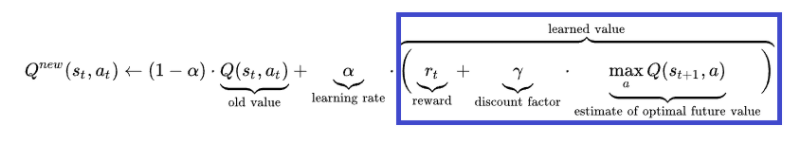

## Mini-project topic: DQN with input as a image

To better understand how we can feed a higher dimension states to reinforcement learning, we can use image as input but with the help of CNN to extract better features. Read this document to see how and implement it here. Then implement DQN on of the Atari game and show your experience in improving your DQN

Attention 1! The demonstration code will not install Atari game. You can read official [site](https://github.com/openai/gym#atari) to install it.  

Attention2: you might face serveral issue to install Atari in google colab. Install it in your local computer is recommended.

[DQN tutorial](https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html)
